In [82]:
%matplotlib

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as plt
import shap
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
import catboost as cb
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split

Using matplotlib backend: agg


In [97]:
#data = pd.read_csv("data_desk.csv")
data = pd.read_csv("data_drp.csv") 
#data = pd.read_csv("data_field.csv")
#data = pd.read_csv("data_open_shop.csv")
#data = pd.read_csv("data_cvp.csv")

In [98]:
data_copy = data.copy()

In [99]:
#Create Scale Map for Ordinal Encoding

scale_mapper1 = {'Total Loss':1, 'Repairable':2}
data_copy['auto_damage_severity_new'] = data_copy['auto_damage_severity'].replace(scale_mapper1)
scale_mapper2 = {'Same Appraiser as Original':1, 'Different Appraiser than Original':2}
data_copy['supplement_appraiser_new'] = data_copy['supplement_appraiser'].replace(scale_mapper2)
scale_mapper3 = {'Driveable':1, 'Non-Driveable':2}
data_copy['drivability_new'] = data_copy['drivability'].replace(scale_mapper3)
data_copy['number_of_vehicles_on_claim'] = data_copy['number_of_vehicles_on_claim'].replace('4 or more', 4)
data_copy[['number_of_vehicles_on_claim']] = data_copy[['number_of_vehicles_on_claim']].fillna(-9999)
data_copy['number_of_vehicles_on_claim'] = pd.to_numeric(data_copy['number_of_vehicles_on_claim'], downcast='integer', errors='coerce')
data_copy = data_copy.drop(columns=['auto_damage_severity'])
data_copy['fabric_ind'] = data_copy['fabric_ind'].replace('Yes', 1)
data_copy['fabric_ind'] = data_copy['fabric_ind'].replace('No', 0)
data_copy[['fabric_ind']] = data_copy[['fabric_ind']].fillna(-9999)
data_copy[['supplement_appraiser_new']] = data_copy[['supplement_appraiser_new']].fillna(-9999)
data_copy['drivability_new'] = data_copy['drivability_new'].replace('x', -9999)
data_copy = data_copy.drop(columns=['drivability', 'supplement_appraiser'])
data_copy

,digital_claim_ind,loss_cause,insured_fault_pct,injury_incident_ind,number_of_vehicles_on_claim,paid_loss_amount,reserve_loss_amount,days_fnol_to_first_close,deductible_amt,reported_by,...,ehinumberofdays,fabric_ind,customer_tenure,age,labor_days,benchmark_column,ces,auto_damage_severity_new,supplement_appraiser_new,drivability_new
0,NaN,Vandalism/Malicious Mischief,NaN,NaN,1,6886.17,NaN,95.0,500.0,Self,...,NaN,0.0,11.0,52.0,16.45,x,1.0,1.0,2.0,2.0
1,NaN,Collision with Motor Vehicle/Watercraft,NaN,NaN,2,2037.82,NaN,7.0,500.0,Self,...,NaN,0.0,20.0,76.0,2.40,x,3.0,2.0,1.0,1.0
2,NaN,Theft,NaN,NaN,1,1021.02,NaN,16.0,250.0,NaN,...,NaN,0.0,7.0,75.0,0.38,x,3.0,2.0,1.0,1.0
3,NaN,Vandalism/Malicious Mischief,NaN,NaN,1,1990.22,NaN,29.0,50.0,Self,...,NaN,0.0,35.0,65.0,6.88,x,3.0,2.0,1.0,1.0
4,NaN,Theft,NaN,NaN,1,4830.42,NaN,48.0,500.0,Agent,...,NaN,0.0,8.0,38.0,6.80,x,2.0,2.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13718,NaN,Hail,NaN,NaN,1,1865.45,NaN,22.0,500.0,Self,...,NaN,-9999.0,4.0,58.0,0.60,x,3.0,NaN,1.0,1.0
13719,NaN,Collision with Roadbed,NaN,NaN,1,15114.19,NaN,21.0,500.0,Self,...,NaN,-9999.0,10.0,69.0,25.95,x,3.0,NaN,1.0,1.0
13720,NaN,Collision with Stationary/Other Object,NaN,NaN,1,669.54,NaN,10.0,500.0,Self,...,NaN,-9999.0,5.0,63.0,1.45,x,3.0,NaN,1.0,1.0
13721,NaN,Collision with Stationary/Other Object,100.0,1.0,1,11946.50,NaN,51.0,1000.0,Self,...,NaN,-9999.0,43.0,90.0,25.08,x,3.0,NaN,1.0,2.0


In [100]:
#Impute and One-Hot Encoding

data_copy[['digital_claim_ind']] = data_copy[['digital_claim_ind']].fillna(0)
data_copy[['insured_fault_pct']] = data_copy[['insured_fault_pct']].fillna(-9999)
data_copy[['injury_incident_ind']] = data_copy[['injury_incident_ind']].fillna(0)
data_copy[['paid_loss_amount', 'reserve_loss_amount']] = data_copy[['paid_loss_amount', 'reserve_loss_amount']].fillna(-9999)
data_copy[['days_fnol_to_first_close']] = data_copy[['days_fnol_to_first_close']].fillna(-9999)
data_copy[['deductible_amt', 'supp_cnt']] = data_copy[['deductible_amt', 'supp_cnt']].fillna(-9999)
data_copy[['repair_days', 'file_start_to_complete_days', 'loss_to_reported_days', 'loss_to_estimate_start_days', 'est_start_to_file_complete_days', 'loss_reported_to_assignment_days', 'assignment_sent_to_retrieved_days', 'estimate_start_to_estimate_complete_days', 'first_supplement_to_last_supplement_days', 'repair_cost_to_regional_value_pct', 'regional_value_amt']] = data_copy[['repair_days', 'file_start_to_complete_days', 'loss_to_reported_days', 'loss_to_estimate_start_days', 'est_start_to_file_complete_days', 'loss_reported_to_assignment_days', 'assignment_sent_to_retrieved_days', 'estimate_start_to_estimate_complete_days', 'first_supplement_to_last_supplement_days', 'repair_cost_to_regional_value_pct', 'regional_value_amt']].fillna(-9999)
data_copy[['customer_tenure', 'age', 'labor_days']] = data_copy[['customer_tenure', 'age', 'labor_days']].fillna(-9999)
data_copy[['reported_by', 'primary_point_of_impact', 'secondary_point_of_impact']] = data_copy[['reported_by', 'primary_point_of_impact', 'secondary_point_of_impact']].fillna('x')
data_copy = pd.get_dummies(data_copy, columns=['loss_cause','reported_by', 'policy_source', 'primary_point_of_impact', 'secondary_point_of_impact'], drop_first=False, dummy_na=False)
data_copy['customer_tenure'] = pd.to_numeric(data_copy['customer_tenure'], downcast='float', errors='coerce')
for column_name in ['customer_tenure', 'age']:
    data_copy[column_name] = data_copy[column_name].astype('float64')
data_copy['benchmark_column'] = data_copy['benchmark_column'].replace('x', -9999)
data_copy[['auto_damage_severity_new']] = data_copy[['auto_damage_severity_new']].fillna(-9999)
data_copy['supplement_appraiser_new'] = data_copy['supplement_appraiser_new'].replace('x', -9999)
data_copy['supplement_appraiser_new'] = pd.to_numeric(data_copy['supplement_appraiser_new'], downcast='integer', errors='coerce')
data_copy

,digital_claim_ind,insured_fault_pct,injury_incident_ind,number_of_vehicles_on_claim,paid_loss_amount,reserve_loss_amount,days_fnol_to_first_close,deductible_amt,supp_cnt,repair_days,...,secondary_point_of_impact_Right Front Pillar,secondary_point_of_impact_Right Quarter Post,secondary_point_of_impact_Right Rear,secondary_point_of_impact_Right T-bone,secondary_point_of_impact_Rollover,secondary_point_of_impact_Total Loss,secondary_point_of_impact_Undercarriage,secondary_point_of_impact_Unknown,secondary_point_of_impact_Vandalized,secondary_point_of_impact_x
0,0.0,-9999.0,0.0,1,6886.17,-9999.0,95.0,500.0,1.0,2.0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,-9999.0,0.0,2,2037.82,-9999.0,7.0,500.0,1.0,-9999.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,-9999.0,0.0,1,1021.02,-9999.0,16.0,250.0,1.0,5.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,-9999.0,0.0,1,1990.22,-9999.0,29.0,50.0,2.0,7.0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,-9999.0,0.0,1,4830.42,-9999.0,48.0,500.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13718,0.0,-9999.0,0.0,1,1865.45,-9999.0,22.0,500.0,-9999.0,2.0,...,0,0,0,0,0,0,0,0,0,0
13719,0.0,-9999.0,0.0,1,15114.19,-9999.0,21.0,500.0,-9999.0,-9999.0,...,0,0,0,0,0,0,0,0,0,0
13720,0.0,-9999.0,0.0,1,669.54,-9999.0,10.0,500.0,-9999.0,-9999.0,...,0,0,0,0,0,0,0,0,0,0
13721,0.0,100.0,1.0,1,11946.50,-9999.0,51.0,1000.0,-9999.0,20.0,...,0,0,0,0,0,0,0,0,0,0


In [101]:
data_copy.replace([np.inf, -np.inf], np.nan, inplace=True)
data_copy.fillna(-999, inplace=True)
data_copy

,digital_claim_ind,insured_fault_pct,injury_incident_ind,number_of_vehicles_on_claim,paid_loss_amount,reserve_loss_amount,days_fnol_to_first_close,deductible_amt,supp_cnt,repair_days,...,secondary_point_of_impact_Right Front Pillar,secondary_point_of_impact_Right Quarter Post,secondary_point_of_impact_Right Rear,secondary_point_of_impact_Right T-bone,secondary_point_of_impact_Rollover,secondary_point_of_impact_Total Loss,secondary_point_of_impact_Undercarriage,secondary_point_of_impact_Unknown,secondary_point_of_impact_Vandalized,secondary_point_of_impact_x
0,0.0,-9999.0,0.0,1,6886.17,-9999.0,95.0,500.0,1.0,2.0,...,0,0,0,0,0,1,0,0,0,0
1,0.0,-9999.0,0.0,2,2037.82,-9999.0,7.0,500.0,1.0,-9999.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,-9999.0,0.0,1,1021.02,-9999.0,16.0,250.0,1.0,5.0,...,0,0,0,0,0,0,0,0,0,0
3,0.0,-9999.0,0.0,1,1990.22,-9999.0,29.0,50.0,2.0,7.0,...,0,1,0,0,0,0,0,0,0,0
4,0.0,-9999.0,0.0,1,4830.42,-9999.0,48.0,500.0,3.0,4.0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13718,0.0,-9999.0,0.0,1,1865.45,-9999.0,22.0,500.0,-9999.0,2.0,...,0,0,0,0,0,0,0,0,0,0
13719,0.0,-9999.0,0.0,1,15114.19,-9999.0,21.0,500.0,-9999.0,-9999.0,...,0,0,0,0,0,0,0,0,0,0
13720,0.0,-9999.0,0.0,1,669.54,-9999.0,10.0,500.0,-9999.0,-9999.0,...,0,0,0,0,0,0,0,0,0,0
13721,0.0,100.0,1.0,1,11946.50,-9999.0,51.0,1000.0,-9999.0,20.0,...,0,0,0,0,0,0,0,0,0,0


In [114]:
#Set Feature and Target Indicators 

X = data_copy
y = data_copy.ces
#X.drop(['ces'], axis=1, inplace=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)

In [115]:
X_train1 = X_train.drop(columns=['ces'])
X_valid1 = X_valid.drop(columns=['ces'])

In [116]:
#Tree-Based Methods
#Define Models

model1 = RandomForestRegressor(n_estimators=200, max_features=2, random_state=0)
model2 = XGBRegressor(n_estimators=200, max_features='auto', random_state=0, learning_rate=0.1)
model3 = ExtraTreesRegressor(n_estimators=200, max_features='auto', random_state=0)
model4 = AdaBoostRegressor(n_estimators=200, random_state=0)
model5 = GradientBoostingRegressor(n_estimators=200, max_features='auto', random_state=0, learning_rate=0.1)
model6 = cb.CatBoostRegressor()

In [117]:
#Tree-Based Methods
#Fit Models

model1.fit(X_train1, y_train)
model2.fit(X_train1, y_train)
model3.fit(X_train1, y_train)
model4.fit(X_train1, y_train)
model5.fit(X_train1, y_train)
model6.fit(X_train1, y_train, verbose=False)

[13:13:42] WARNING: ../src/learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




RMSE: 0.5042855593002454
MAE: 0.3041912568306011
MAPE: 17.7 %


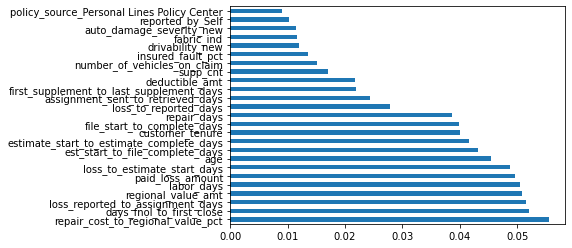

In [152]:
#Tree-Based Methods
#Random Forest

from matplotlib import pyplot
%matplotlib inline

feat_importances = pd.Series(model1.feature_importances_, index=X_valid1.columns)
fig1 = feat_importances.nlargest(25).plot(kind='barh')

preds = model1.predict(X_valid1)

lin_mse = np.sqrt(mean_squared_error(y_valid, preds))
print ('RMSE:', lin_mse)
mae = mean_absolute_error(y_valid, preds)
print('MAE:', mae)

mape = 100 * mean_absolute_percentage_error(y_valid, preds)
print('MAPE:',str(round(mape, 2)),'%')

pyplot.show()
#pyplot.savefig('desk/desk_random_forest.png')
#pyplot.savefig('drp/drp_random_forest.png')
#pyplot.savefig('field/field_random_forest.png')
#pyplot.savefig('open_shop/open_shop_random_forest.png')
#pyplot.savefig('cvp/cvp_random_forest.png')

In [149]:
explainer = shap.TreeExplainer(model1)

In [150]:
X_valid1.loc[[577]]

,digital_claim_ind,insured_fault_pct,injury_incident_ind,number_of_vehicles_on_claim,paid_loss_amount,reserve_loss_amount,days_fnol_to_first_close,deductible_amt,supp_cnt,repair_days,...,secondary_point_of_impact_Right Front Pillar,secondary_point_of_impact_Right Quarter Post,secondary_point_of_impact_Right Rear,secondary_point_of_impact_Right T-bone,secondary_point_of_impact_Rollover,secondary_point_of_impact_Total Loss,secondary_point_of_impact_Undercarriage,secondary_point_of_impact_Unknown,secondary_point_of_impact_Vandalized,secondary_point_of_impact_x
577,0.0,-9999.0,1.0,2,-9999.0,7.0,-9999.0,500.0,-9999.0,-9999.0,...,0,0,0,0,0,0,0,0,0,0


In [151]:
# Calculate Shap values
choosen_instance = X_valid.loc[[577]]
shap_values = explainer.shap_values(choosen_instance)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], choosen_instance)

In [1]:
#shap_values = explainer.shap_values(X_valid)
#shap.summary_plot(shap_values, X_train)

RMSE: 0.5130413698822329
MAE: 0.3030220522038055
MAPE: 17.38 %


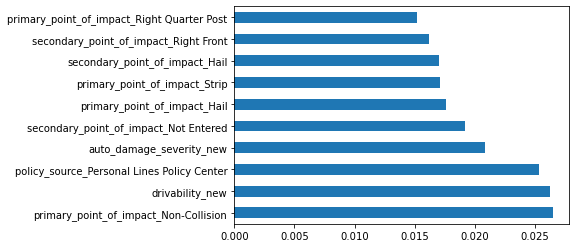

In [131]:
#Tree-Based Methods
#XGBoost

%matplotlib inline

feat_importances2 = pd.Series(model2.feature_importances_, index=X_valid1.columns)
feat_importances2.nlargest(10).plot(kind='barh')

preds = model2.predict(X_valid1)

lin_mse = np.sqrt(mean_squared_error(y_valid, preds))
print ('RMSE:', lin_mse)
mae = mean_absolute_error(y_valid, preds)
print('MAE:', mae)

mape = 100 * mean_absolute_percentage_error(y_valid, preds)
print('MAPE:',str(round(mape, 2)),'%')

pyplot.show()
#pyplot.savefig('desk/desk_xgboost.png')
#pyplot.savefig('drp/drp_xgboost.png')
#pyplot.savefig('field/field_xgboost.png')
#pyplot.savefig('open_shop/open_shop_xgboost.png')
#pyplot.savefig('cvp/cvp_xgboost.png')

RMSE: 0.5404897849638541
MAE: 0.3123806921675774
MAPE: 17.69 %


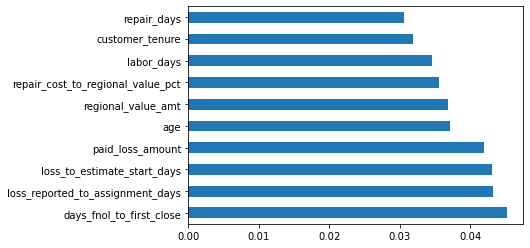

In [80]:
#Tree-Based Methods
#Extra Trees

%matplotlib inline

feat_importances3 = pd.Series(model3.feature_importances_, index=X.columns)
feat_importances3.nlargest(10).plot(kind='barh')

preds = model3.predict(X_valid)

lin_mse = np.sqrt(mean_squared_error(y_valid, preds))
print ('RMSE:', lin_mse)
mae = mean_absolute_error(y_valid, preds)
print('MAE:', mae)
mape = 100 * mean_absolute_percentage_error(y_valid, preds)
print('MAPE:',str(round(mape, 2)),'%')

#pyplot.savefig('desk/desk_extra_trees.png')
#pyplot.savefig('drp/drp_extra_trees.png')
#pyplot.savefig('field/field_extra_trees.png')
#pyplot.savefig('open_shop/open_shop_extra_trees.png')
#pyplot.savefig('cvp/cvp_extra_trees.png')

RMSE: 0.4722694331299971
MAE: 0.2884843320467481
MAPE: 16.05 %


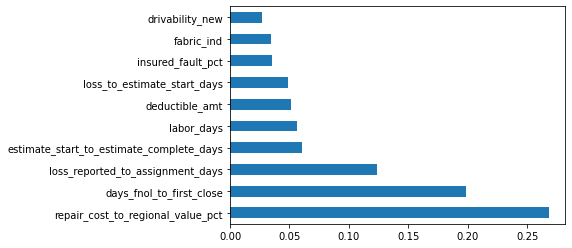

In [64]:
#Tree-Based Methods
#Adaboost

%matplotlib inline

feat_importances4 = pd.Series(model4.feature_importances_, index=X.columns)
feat_importances4.nlargest(10).plot(kind='barh')

preds = model4.predict(X_valid)

lin_mse = np.sqrt(mean_squared_error(y_valid, preds))
print ('RMSE:', lin_mse)
mae = mean_absolute_error(y_valid, preds)
print('MAE:', mae)
mape = 100 * mean_absolute_percentage_error(y_valid, preds)
print('MAPE:',str(round(mape, 2)),'%')

#pyplot.savefig('desk/desk_adaboost.png')
#pyplot.savefig('drp/drp_adaboost.png')
#pyplot.savefig('field/field_adaboost.png')
#pyplot.savefig('open_shop/open_shop_adaboost.png')
#pyplot.savefig('cvp/cvp_adaboost.png')

RMSE: 0.4691487990571077
MAE: 0.28028797925988497
MAPE: 15.5 %


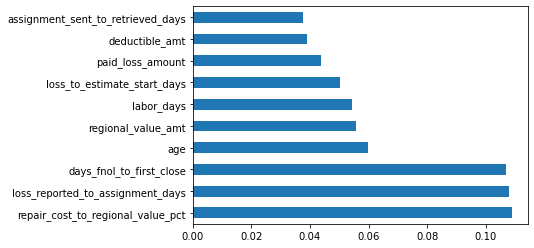

In [65]:
#Tree-Based Methods
#Gradient Boosting
%matplotlib inline

feat_importances5 = pd.Series(model5.feature_importances_, index=X.columns)
feat_importances5.nlargest(10).plot(kind='barh')
pyplot.savefig('desk/desk_gradient_boost.png')

preds = model5.predict(X_valid)

lin_mse = np.sqrt(mean_squared_error(y_valid, preds))
print ('RMSE:', lin_mse)
mae = mean_absolute_error(y_valid, preds)
print('MAE:', mae)
mape = 100 * mean_absolute_percentage_error(y_valid, preds)
print('MAPE:',str(round(mape, 2)),'%')

#pyplot.savefig('desk/desk_gradient_boost.png')
#pyplot.savefig('drp/drp_gradient_boost.png')
#pyplot.savefig('field/field_gradient_boost.png')
#pyplot.savefig('open_shop/open_shop_gradient_boost.png')
#pyplot.savefig('cvp/cvp_gradient_boost.png')

''

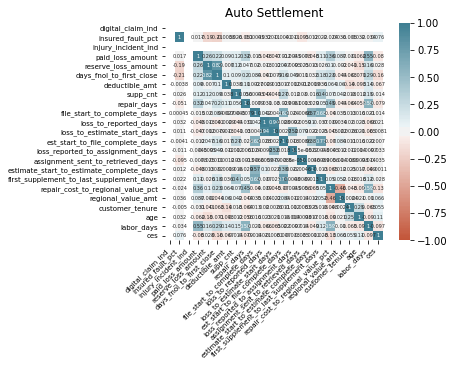

In [67]:
#Pairewise Correlation and Correlation with Target 


In [68]:
# Sequential Forward Selection(sfs)

from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from sklearn.linear_model import LinearRegression
sfs = SFS(LinearRegression(),
          k_features=5,
          forward=True,
          floating=False,
          scoring = 'r2',
          cv = 0)
sfs.fit(X,y)
sfs.k_feature_names_

('injury_incident_ind',
 'regional_value_amt',
 'fabric_ind',
 'loss_cause_Collision with Motor Vehicle/Watercraft',
 'primary_point_of_impact_Total Loss')

In [69]:
#Sequential backward selection(sbs)

sbs = SFS(LinearRegression(),
         k_features=5,
         forward=False,
         floating=False,
          scoring = 'r2',
         cv=0)
sbs.fit(X,y)
sbs.k_feature_names_

('primary_point_of_impact_Hail',
 'primary_point_of_impact_Left & Right Side',
 'primary_point_of_impact_Rear',
 'primary_point_of_impact_Total Loss',
 'primary_point_of_impact_x')

In [ ]:
#LASSO Regression & Feature Selection

from sklearn.linear_model import Lasso
from sklearn.linear_model import LinearRegression

#RMSE: 1.1669955074365097
#MAE: 0.8221991480298191